In [2]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

import utils
import utils.logging_config
import logging
logger = logging.getLogger("task2 (mesh)")

In [3]:
DATA_ROOT = Path('data')
# DATA_NAME = 'data0.txt'
# DATA_NAME = 'data1.txt'
# DATA_NAME = 'data0_noise.txt'
DATA_NAME = "data1_noise.txt"
NBINS = 30
CACHE_ROOT = Path('.cache')

G = 1

In [4]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")
# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]

15:36:38 - utils.load - Loaded 9913 rows and 9 columns from data/data1_noise.txt


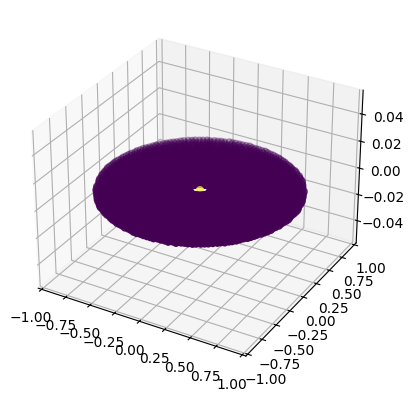

In [5]:
# plot the distribution of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(particles[:,0], particles[:,1], particles[:,2], cmap='viridis', c=particles[:,3])
plt.show()
## Note: colormap corresponds to the mass of the particles

### Choice of units
Recap of the particle properties:
- $\sim 10^4$ particles
- around 1 black hole (10% of the mass)

$\implies$ ???

In [6]:
# Set G = 1
G = 1

# from the particle number we can estimate the total (stellar) mass, excluding the BH
M_TOT = 1e4 * u.M_sun
# the radius aound the black hole follows from ??? # TODO
R_TOT = 1 * u.pc

# Rescale the units of the particles - considering only the orbiting stars
M_particles = particles[:,3].sum() - 1
R_particles = np.max(np.linalg.norm(particles[:, :3], axis=1))

logger.info(f"Considering a globular cluster - total mass of stars: {M_particles}, maximum radius of particles: {R_particles}")
m_scale = M_TOT / M_particles
r_scale = R_TOT / R_particles
utils.seed_scales(r_scale, m_scale)


15:36:38 - task2 (mesh) - Considering a globular cluster - total mass of stars: 9.999999999999998, maximum radius of particles: 0.9096731180509756
15:36:38 - utils.units - Set scales: M_SCALE = 1e+03 solMass, R_SCALE = 1.1 pc


In [7]:
### Direct N body force computation
epsilon = utils.mean_interparticle_distance(particles)

epsilon_range = np.logspace(-2, 2, 5)
n_squared_forces = []

SAVE_FORCES = False

for e in epsilon_range:
    n_particles = particles.shape[0]
    cache_file = CACHE_ROOT / f"n_squared_forces__n_{n_particles}__softening_multiplier_{e:.0f}.npy"
    try:
        f = np.load(cache_file)
        logger.info(f"Loaded forces from {cache_file}")
    except FileNotFoundError:
        f = utils.n_body_forces(particles, G, e * epsilon)
        if SAVE_FORCES:
            np.save(cache_file, f)
            logger.debug(f"Saved forces to {cache_file}")
    n_squared_forces.append(f)

### Mesh based force computation
mesh_size_range = [10, 20, 50, 100, 150, 200]
mapping = utils.particle_to_cells_nn

mesh_forces = []
for mesh_size in mesh_size_range:
    cache_file = CACHE_ROOT / f"mesh_forces__n_{n_particles}__mesh_size_{mesh_size}__mapping_{mapping.__name__}.npy"
    try:
        f = np.load(cache_file)
        logger.info(f"Loaded forces from {cache_file}")
    except FileNotFoundError:
        f = utils.mesh_forces_v2(particles, G, mesh_size, mapping)
        if SAVE_FORCES:
            np.save(cache_file, f)
            logger.debug(f"Saved forces to {cache_file}")
    mesh_forces.append(f)


15:36:38 - utils.particles - Found mean interparticle distance: 0.0262396757880128


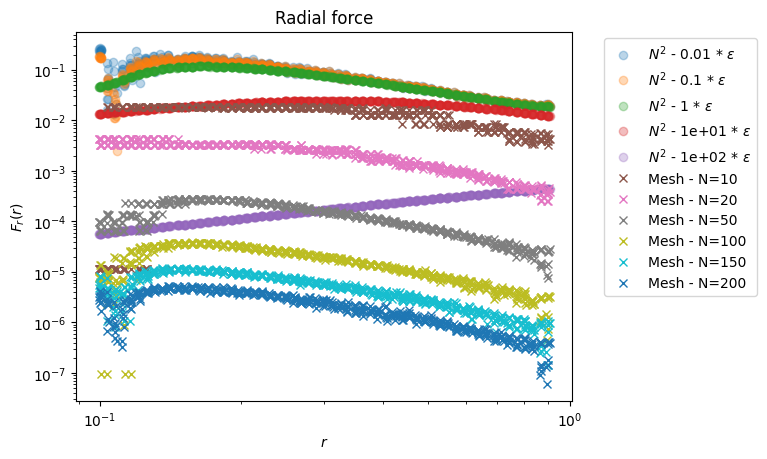

In [8]:
## Compare the mesh computation with the direct summation
r = np.linalg.norm(particles[:,:3], axis=1)

plt.figure()
plt.title('Radial force')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$')
plt.ylabel('$F_r(r)$')

# many of the particles have the same distance from the origin, so we skip some of them
SKIP_N = 20

for f,e in zip(n_squared_forces, epsilon_range):
    plt.plot(r[::SKIP_N], np.linalg.norm(f, axis=1)[::SKIP_N], 'o', label=f"$N^2$ - {e:.1g} * $\\epsilon$", alpha=0.3)
for f, s in zip(mesh_forces, mesh_size_range):
    plt.plot(r[::SKIP_N], np.linalg.norm(f, axis=1)[::SKIP_N], 'x', label=f"Mesh - N={s}")

# plt.ylim([5e-4, 1e2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# TODO: compare computation time


#### Discussion
- Using the baseline of $N^2 + 1 \varepsilon$ softening we can see that already a 20 x 20 x 20 grid provides good accuracy but the mapping breaks down at small distances (dip)
- Larger grids are more stable, especially at small distances => 50 x 50 x 50 already seems to be a good choice
- very large grids show overdiscretization => noisy data even for the non-noisy particle distributions


### Time integration

In [9]:
import scipy.integrate as spi

In [10]:
# load the particles in the format [x, y, z, vx, vy, vz, mass]
p0 = points[:, [2, 3, 4, 5, 6, 7, 1]]
# p0 = p0[::10] # only take a subset for now

logger.info(f"Considering {p0.shape[0]} particles")
logger.info(f"Total mass: {np.sum(p0[:,6])}")

if logger.level >= logging.DEBUG:
    # assert that the ODE reshaping is consistent
    logger.debug(f"{p0[0]}, {p0[1]}")
    y0, _ = utils.ode_setup(p0, None)
    logger.debug(y0[0:7])
    p0_reconstructed = utils.to_particles(y0)
    logger.debug(p0_reconstructed[0])
    assert np.allclose(p0, p0_reconstructed)


15:36:57 - task2 (mesh) - Considering 9913 particles


15:36:57 - task2 (mesh) - Total mass: 10.999999999999998


In [38]:
# Determine the integration timesteps
# let's first compute the crossing time
m_half = np.sum(particles[:, 3]) / 2
r_half = utils.half_mass_radius(particles)

v_c = np.sqrt(G * m_half / r_half)
t_c = r_half / v_c
# a single timestep should result in a small displacement, wrt. to the mean interparticle distance
r_inter = utils.mean_interparticle_distance(particles)
dt = t_c * r_inter / r_half * 0.01
logger.info(f"Crossing time: {t_c}, timestep: {dt}")
# dt = 0.01
n_steps = 10
t_range = np.arange(0, n_steps*dt, dt)


15:57:21 - utils.particles - Found mean interparticle distance: 0.0262396757880128
15:57:21 - task2 (mesh) - Crossing time: 0.059139749002184876, timestep: 5.7915844560794737e-05


In [45]:
# The force function can be interchanged
force_function = lambda x: utils.n_body_forces(x, G, epsilon) # epsilon was computed above
force_function = lambda x: utils.analytical_forces(x)# just for lols
# force_function = lambda x: utils.mesh_forces_v2(x, G, 50, utils.particle_to_cells_nn)

y0, y_prime = utils.ode_setup(p0, force_function)

In [46]:
# finally, integrate the system

## either use the scipy integrator
# sol = spi.odeint(y_prime, y0, t_range, rtol=1e-2)

# # or do it ourselves, for instance by using rk4
sol = np.zeros((t_range.shape[0], y0.shape[0]))
sol[0] = y0
for i in range(1, t_range.shape[0]):
    t = t_range[i]
    sol[i,...] = utils.runge_kutta_4(sol[i-1], t, y_prime, dt)


logger.info(f"Integration done, shape: {sol.shape}")

/home/remy/Documents/Uni/HS24/Computational Astrophysics/projects/nbody/utils/forces_basic.py:71: RuntimeWarning: invalid value encountered in scalar divide
  f = - m_current * m_enclosed / r_current**2
16:03:32 - task2 (mesh) - Integration done, shape: (10, 69391)


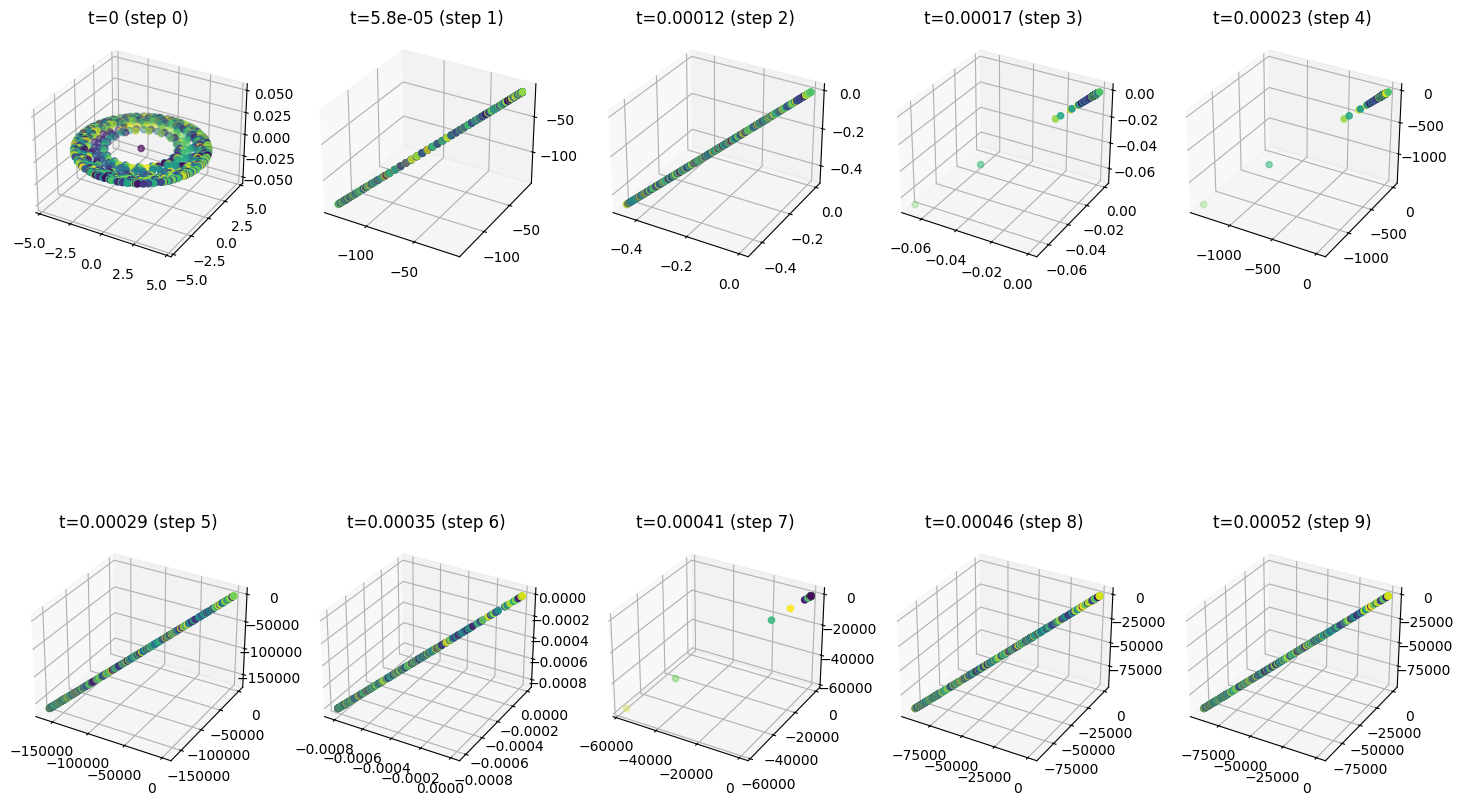

In [47]:
### Plot a fixed number of states
N_STATES = 10 # should be even
# skip some particles to make the plot more readable
SKIP_NTH_PARTICLE = 10


fig, axs = plt.subplots(2, N_STATES//2, subplot_kw={'projection': '3d'})

for i, ax in enumerate(axs.flat):
    nth = int(sol.shape[0] / N_STATES) * i
    p = utils.to_particles(sol[nth])[::SKIP_NTH_PARTICLE]
    ax.scatter(p[:,0], p[:,1], p[:,2], cmap='viridis', c=range(p.shape[0]))
    ax.set_title(f"t={t_range[nth]:.2g} (step {nth})")
# set size
fig.set_size_inches(18, 12)

plt.show()

# # Also show the velocities
# scale = 1e-2
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# p_reduced = plast[::10]
# ax.quiver(p_reduced[:,0], p_reduced[:,1], p_reduced[:,2], p_reduced[:,3], p_reduced[:,4], p_reduced[:,5], length=0.1, normalize=True)
# plt.show()

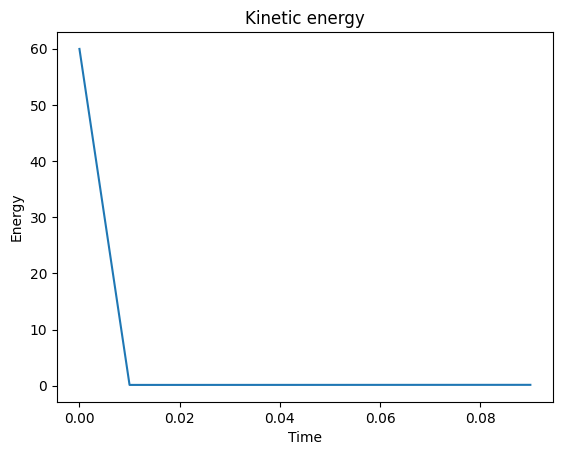

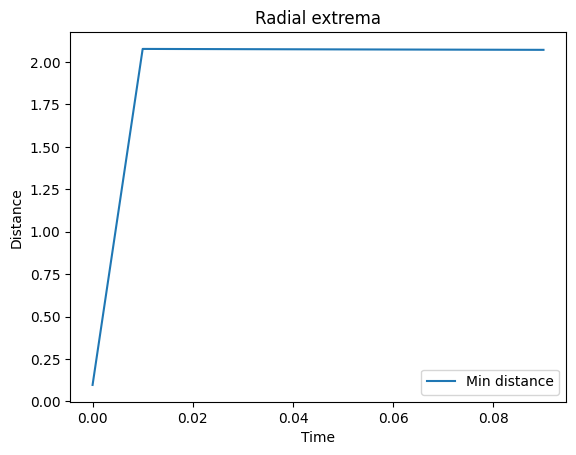

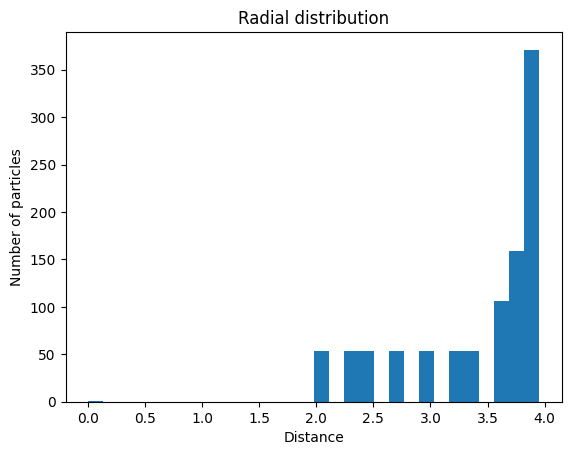

In [23]:
#### Plot some key quantities of the system as a whole
# sol has the shape (n_steps, n_particles*6) where the first 3*n are the positions and the last 3*n are the velocities

# kinetic energy
energies = np.zeros(sol.shape[0])
for i in range(sol.shape[0]):
    p = utils.to_particles(sol[i])
    k_e = 0.5 * np.sum(p[:,6] * np.linalg.norm(p[:,3:6], axis=1)**2)
    energies[i] = k_e

plt.figure()
plt.plot(t_range, energies)
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()


# radial extrema of the particles
r_mins = np.zeros(sol.shape[0])
r_maxs = np.zeros(sol.shape[0])
for i in range(sol.shape[0]):
    p = utils.to_particles(sol[i])
    r = np.linalg.norm(p[:,:3], axis=1)
    r_mins[i] = np.partition(r, 4)[4]

    # r_mins[i] = np.min(r)
    r_maxs[i] = np.max(r)

plt.figure()
plt.plot(t_range, r_mins, label='Min distance')
# plt.plot(t_range, r_maxs, label='Max distance')
plt.title('Radial extrema')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()

# plot the last radial distribution
plt.figure()
plt.hist(r, bins=NBINS)
plt.title('Radial distribution')
plt.xlabel('Distance')
plt.ylabel('Number of particles')
plt.show()
